# 프레임 단위로 보았을 때, 사람구별이 가능한가?

In [23]:
#임창정
import librosa
x , sr_x = librosa.load('C:/Users/wnduq/Desktop/Python_code/voicepro/김범수 - 보고싶다 무반주 (역대급 라이브).mp3')
x = x[22000*0:22000*5]
frame_length = 0.025
frame_stride = 0.0125
sr = 22000
input_nfft = int(round(sr * frame_length))
input_stride = int(round(sr * frame_stride))
mfcc_1 = librosa.feature.mfcc(x , sr=sr_x, n_mfcc=20, fmax=5000, n_fft=input_nfft, hop_length=input_stride)
# 초당 40장???
mfcc_1 = mfcc_1.T
name_1 = ['김범수'] * len(mfcc_1)

In [ ]:
발성이 바뀌는 구간 캐치?

In [30]:
mfcc_1.shape

(401, 20)

In [22]:
#나얼
import librosa
x , sr_x = librosa.load('C:/Users/wnduq/Desktop/Python_code/voicepro/[나얼]  바람기억 무반주 라이브.mp3')
x = x[22000*0:22000*5]
frame_length = 0.025
frame_stride = 0.0125
sr = 22000
input_nfft = int(round(sr * frame_length))
input_stride = int(round(sr * frame_stride))
mfcc_2 = librosa.feature.mfcc(x , sr=sr_x, n_mfcc=20, fmax=5000, n_fft=input_nfft, hop_length=input_stride)
# 초당 40장???
mfcc_2 = mfcc_2.T
name_2 = ['나얼'] * len(mfcc_2)

In [29]:
mfcc = np.concatenate([mfcc_1,mfcc_2])

(802, 20)

In [33]:
name = name_1 +name_2

In [31]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit(mfcc)
scaled_X = scale.transform(mfcc)

In [32]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
import numpy as np
import tensorflow as tf
from functools import partial

################
# layer params #
################
n_inputs = 20
n_hidden1 = 10  # encoder
n_hidden2 = 2  # coding units
n_hidden3 = n_hidden1  # decoder
n_outputs = n_inputs  # reconstruction

################
# train params #
################
learning_rate = 0.01
l2_reg = 0.0001
n_epochs = 400
batch_size = 80
n_batches = len(scaled_X) // batch_size

# set the layers using partial
he_init = tf.keras.initializers.he_normal()  # He 초기화
l2_regularizer = tf.contrib.layers.l2_regularizer(scale=l2_reg)  # L2 규제
dense_layer = partial(tf.layers.dense,
                      activation=tf.nn.elu,
                      kernel_initializer=he_init,
                      kernel_regularizer=l2_regularizer)

# stacked autoencoder
inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden1 = dense_layer(inputs, n_hidden1)
hidden2 = dense_layer(hidden1, n_hidden2)
hidden3 = dense_layer(hidden2, n_hidden3)
outputs = dense_layer(hidden3, n_outputs, activation=None)

# loss
reconstruction_loss = tf.reduce_mean(tf.square(outputs - inputs))
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Train
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            X_batch, y_batch = next(shuffle_batch(scaled_X, scaled_X, batch_size))
            sess.run(train_op, feed_dict={inputs: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={inputs: X_batch})
        if epoch % 100 ==0:
            print('epoch : {}, Train MSE : {:.5f}'.format(epoch, loss_train))
    x_2dim = hidden2.eval(feed_dict={inputs: scaled_X})        

epoch : 0, Train MSE : 1.03914
epoch : 100, Train MSE : 0.27895
epoch : 200, Train MSE : 0.27961
epoch : 300, Train MSE : 0.27874


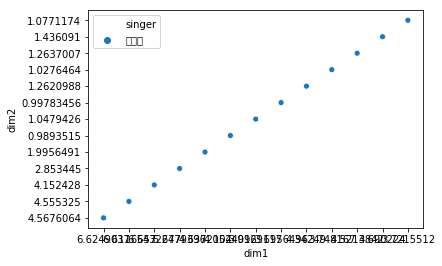

In [40]:
#PCA
import pandas as pd
from sklearn.decomposition import PCA
new = np.c_[x_2dim, name]
df  = pd.DataFrame(new,columns=['dim1','dim2','singer'])

#polting
import seaborn as sns
sns.scatterplot(x='dim1',y='dim2',hue = 'singer',data =df.iloc[:20,:])

In [37]:
df.iloc[:10,:]

,dim1,dim1,singer
0,6.6249037,4.5676064,김범수
1,6.6249037,4.5676064,김범수
2,6.6249037,4.5676064,김범수
3,6.6249037,4.5676064,김범수
4,6.6249037,4.5676064,김범수
5,6.6249037,4.5676064,김범수
6,6.6249037,4.5676064,김범수
7,6.6249037,4.5676064,김범수
8,6.6116657,4.555325,김범수
9,6.5432677,4.152428,김범수
